In [1]:
# Import

import epics
import numpy
import pandas
import torch
import nufft
import yaml

import sys
sys.path.append('..')

from harmonica.util import LENGTH, data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

True
6


# Example-01: FFT amplitude spectrum

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))


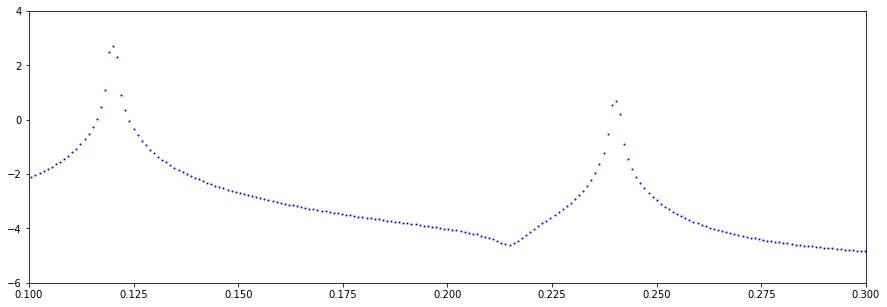

In [2]:
# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instance
f = Frequency(d)
print(f)

# Apply window (note, window is applied to work)
d.window_remove_mean()
d.window_apply()

# FFT grid is stored in fft_grid (computed on initialization)
# FFT spectrum amplitudes are stored in fft_spectrum for each signal

# Compute FFT amplitude spectrum
f.fft_get_spectrum()

# Reset TbT work (copy data to work)
f.data.reset()

# Plot (log10) FFT spectrum for given signal id
idx = 0
plt.figure(figsize=(15,5))
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=1, c='b')
plt.xlim(0.1, 0.3)
plt.ylim(-6.0, 4.0)
plt.show()

# Clean
del w
del t, data
del d
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-02: FFT amplitude spectrum & zero padding

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))


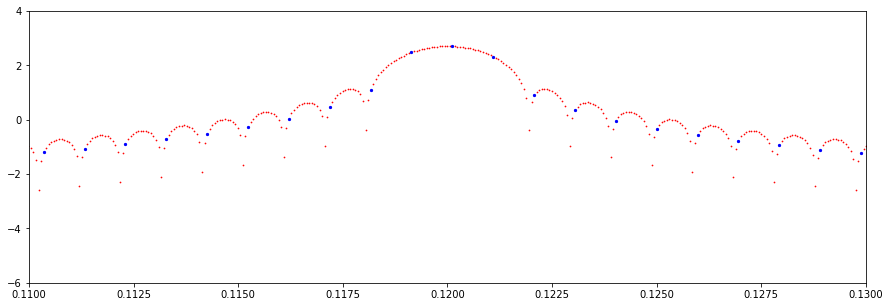

In [3]:
# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# If pad == 0, it is set to signal length
# Spectrum is computed using torch.fft.rfft(..., n=pad)/torch.fft.fft(..., n=pad) for real/complex input
# Padding can be used to interpolate DTFT spectrum in all frequency range
# This improves frequency estimation accuracy (assuming frequency corresponds to max of the largest FFT spectrum amplitude peak)
# Can be used to obtain a better initial guess, if signal has several frequencies with close amplitudes

# Initialize Frequency instances with and without padding
f1 = Frequency(d, pad=length*2**4)
f2 = Frequency(d, pad=length*2**0)
print(f1)
print(f2)

# Apply window (note, window is applied to work)
d.window_remove_mean()
d.window_apply()

# Compute FFT amplitude spectrum
f1.fft_get_spectrum()
f2.fft_get_spectrum()

# Reset TbT work
f1.data.reset()
f2.data.reset()


# Plot (log10) FFT spectrum for given signal id
idx = 0
plt.figure(figsize=(15,5))
plt.scatter(f1.fft_grid.detach().cpu(), torch.log10(f1.fft_spectrum[idx].detach().cpu()), s=0.5, c='r')
plt.scatter(f2.fft_grid.detach().cpu(), torch.log10(f2.fft_spectrum[idx].detach().cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.ylim(-6.0, 4.0)
plt.show()

# Clean
del w
del t, data
del d
del f1, f2
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-03: FFT frequency estimation & zero padding

In [4]:
# FFT frequency estimation is based on location of max bin in the amplitude spectum

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instances with and without padding
f1 = Frequency(d, pad=length*2**0)
f2 = Frequency(d, pad=length*2**4)
print(f1)
print(f2)

# Apply window (note, window is applied to work)
d.window_remove_mean()
d.window_apply()

# Estimate frequency
f1('fft')
f2('fft')

# Compare results
print(torch.abs(f1.frequency.mean() - 0.12))
print(torch.abs(f2.frequency.mean() - 0.12))

# In this case call invokes task_fft method
f1.task_fft()
f2.task_fft()

# Compare results
print(torch.abs(f1.fft_frequency.mean() - 0.12))
print(torch.abs(f2.fft_frequency.mean() - 0.12))

# Clean
del w
del t, data
del d
del f1, f2
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(4.882812499996e-06, dtype=torch.float64)
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(4.882812499996e-06, dtype=torch.float64)


# Example-04: FFT frequency estimation & zero padding for given range

In [5]:
# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instances with and without padding
f1 = Frequency(d, pad=length*2**0)
f2 = Frequency(d, pad=length*2**4)
print(f1)
print(f2)

# Apply window (note, window is applied to work)
d.window_remove_mean()
d.window_apply()

# By default FFT frequency estimation is performed using (0.0, 0.5) frequency range.
# Explicit range can be passed.

# Estimate frequency for explicit frequency range
f1('fft', f_range=(0.2, 0.25))
f2('fft', f_range=(0.2, 0.25))

# Compare results
print(torch.abs(f1.frequency.mean() - 0.24))
print(torch.abs(f2.frequency.mean() - 0.24))

# Clean
del w
del t, data
del d
del f1, f2
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(2.343750000000e-04, dtype=torch.float64)
tensor(9.765624999991e-06, dtype=torch.float64)


# Example-05: FFRFT/ZOOM amplitude spectrum

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor([1.191406250000e-01, 1.210918426514e-01], dtype=torch.float64)
tensor([1.191406250000e-01, 1.210937500000e-01], dtype=torch.float64)
tensor([1.191406250000e-01, 1.210937500000e-01], dtype=torch.float64)


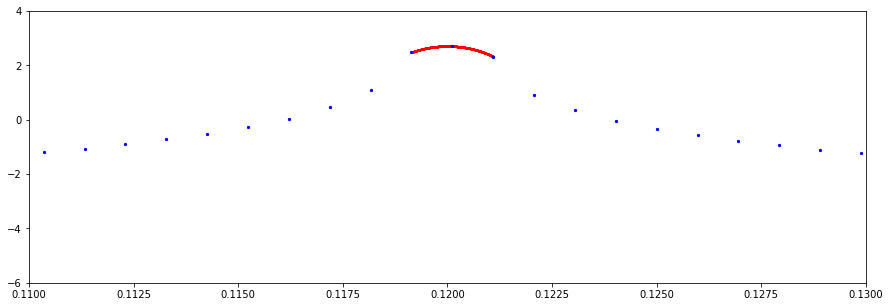

tensor([1.150000000000e-01, 1.249902343750e-01], dtype=torch.float64)
tensor([1.150000000000e-01, 1.250000000000e-01], dtype=torch.float64)


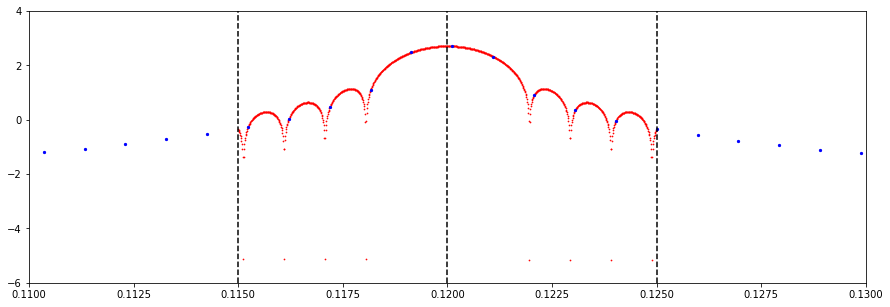

In [6]:
# FFRFT can be used for local DTFT spectrum interpolation

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instance
f = Frequency(d)
print(f)

# Apply window (note, window is applied to work)
d.window_remove_mean()
d.window_apply()

# Compute FFT amplitude spectrum
f.fft_get_spectrum()

# By default for FFRFT spectrum, FFT frequency estimation is used
# And frequency range is equal to 2 FFT bins around max FFT bin
# This can be changed by setting fraction parameter on initialization
# Or by setting ffrft_span attibute directry after initialization
# Use default value.
f.ffrft_span = 2.0/f.length

# If ffrft_flag is False, ffrft_initialize_spectrum is invoked
# ffrft_flag is set to True, futher calls do not reinitialize FFRFT
# No need to initialize for fixed signal length

# Compute FFT frequency estimation (used to define FFRFT frequency center)
f.fft_get_frequency()

# Compute FFRFT amplitude spectrum
f.ffrft_get_spectrum()

# Note, last point is not included
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1]]))
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1] + f.ffrft_span*f.fft_step]))
print(torch.stack([f.fft_frequency[0] - f.fft_step, f.fft_frequency[0] + f.fft_step]))

# Plot (log10) FFT spectrum for given signal id
idx = 0
plt.figure(figsize=(15,5))
plt.scatter(f.ffrft_get_grid(idx).cpu(), torch.log10(f.ffrft_spectrum[idx].cpu()), s=0.5, c='r')
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.ylim(-6.0, 4.0)
plt.show()

# FFRFT can be used with custom range
# In this case all signals share this range, while for the default case, each signal range is defined by its FFT frequency
# In all cases range length is the same for all signals

# Compute FFRFT amplitude spectrum with custom range
# Range (f_min, f_max) = (center - 0.5*span, center + 0.5*span - span/length)
f.ffrft_get_spectrum(center=0.12, span=0.01)

# Note, last point is not included
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1]]))
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1] + f.ffrft_span*f.fft_step]))

# Plot (log10) FFT spectrum for given signal id
idx = 0
plt.figure(figsize=(15,5))
plt.scatter(f.ffrft_get_grid(idx).cpu(), torch.log10(f.ffrft_spectrum[idx].cpu()), s=0.5, c='r')
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.ylim(-6.0, 4.0)
plt.vlines(0.12, -6.0, 4.0, colors='black', linestyles='dashed')
plt.vlines(0.12 - 0.01/2, -6.0, 4.0, colors='black', linestyles='dashed')
plt.vlines(0.12 + 0.01/2, -6.0, 4.0, colors='black', linestyles='dashed')
plt.show()

# Clean
del w
del t, data
del d
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-06: FFRFT/ZOOM frequency estimation

In [7]:
# FFRFT frequency estimation is based on local DTFT spectrum interpolation (near expected global maximum)
# By default refined spectum is computed inside two FFT bins around maximum bin
# In this case expected frequency error is proportional to 1/n^2

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instance
f1 = Frequency(d)
f2 = Frequency(d, pad=8192, fraction=1.0)
print(f1)
print(f2)

# Apply window (note, window is applied to work)
d.window_remove_mean()
d.window_apply()

# Fraction between 1.0-2.0 should be save to use

# Estimate frequency, see also task_ffrft
f1('ffrft')
f2('ffrft')

# Compare results FFT & FFRFT estimations
print(torch.abs(f1.fft_frequency.mean() - 0.12))
print(torch.abs(f2.fft_frequency.mean() - 0.12))
print(torch.abs(f1.ffrft_frequency.mean() - 0.12))
print(torch.abs(f2.ffrft_frequency.mean() - 0.12))

# Clean
del w
del t, data
del d
del f1, f2
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(4.882812499996e-06, dtype=torch.float64)
tensor(8.392333984419e-07, dtype=torch.float64)
tensor(1.144409179643e-07, dtype=torch.float64)


# Example-07: Parabola frequency estimation

In [8]:
# Parabola frequency estimation is based on parabolic interpolation of FFRFT amplitude spectrum
# Three points are used to locate parabola maximum (FFRFT max bin and two poins around it)
# Higher order polynomial can be used or a gradient free bracketing maximum search
# Instead of interpolation, a polynomial (e.g. a parabola) can be fitted near the peak maximum
# Without noise, parabolic interpolation significantly improves estimation accuracy
# Window order impoves accuracy in this case too (flat top)
# With noise accuracy gain from parabolic interpolation decreases
# Application of window increases noise

# Set parameters (64 signals with length 1024)
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)
t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instance
f = Frequency(d)
print(f)

# Apply window (note, window is applied to work)
d.window_remove_mean()
d.window_apply()

# Estimate frequency, see also task_parabola
f('parabola')

# Compare results
print(torch.abs(torch.mean(f.fft_frequency)-0.12))
print(torch.abs(torch.mean(f.ffrft_frequency)-0.12))
print(torch.abs(torch.mean(f.parabola_frequency)-0.12))

# Clean
del w
del t, data
del d
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(8.392333984419e-07, dtype=torch.float64)
tensor(3.024490380366e-11, dtype=torch.float64)


# Example-08: Frequency vs signal start shift

Window(8192, 'cosine_window', 1.0)
Data(1, Window(8192, 'cosine_window', 1.0))
Data(7169, Window(1024, 'cosine_window', 1.0))
Frequency(Data(7169, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(8.392333984419e-07, dtype=torch.float64)
tensor(1.861150122906e-13, dtype=torch.float64)


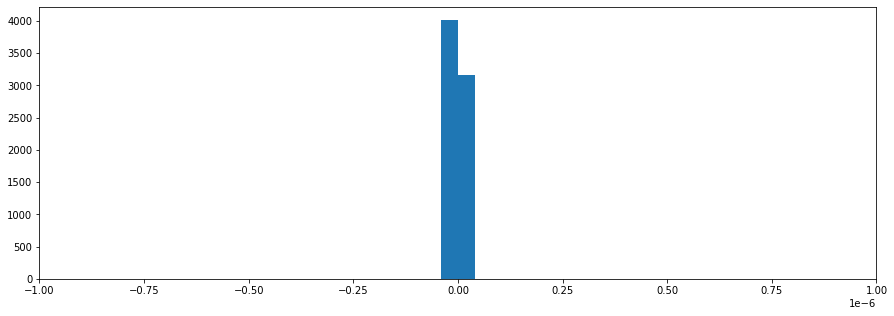

tensor(2.584960914924e-11, dtype=torch.float64)


In [9]:
# Set parameters (1 signal with length 8192)
dtype, device = torch.float64, 'cpu'
size, length = 1, 8192

# Set window
w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (1 signals with two components)
t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Generate matrix shifted signal
data = d.make_matrix(1024, 1, d.data[0])
w = Window.from_cosine(1024, order=1.0, dtype=dtype, device=device)
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instance
f = Frequency(d)
print(f)

# Apply window (note, window is applied to work)
d.window_remove_mean()
d.window_apply()

# Estimate frequency, see also task_parabola
f('parabola')

# Compare results
print(torch.abs(torch.mean(f.fft_frequency)-0.12))
print(torch.abs(torch.mean(f.ffrft_frequency)-0.12))
print(torch.abs(torch.mean(f.parabola_frequency)-0.12))

# Plot result
plt.figure(figsize=(15,5))
plt.hist(100*(f.frequency.cpu().numpy()-0.12)/0.12, bins=50, range=(-1.0E-6, +1.0E-6))
plt.xlim(-1.0E-6, +1.0E-6)
plt.show()

# Spread
print(f.parabola_frequency.std().cpu())

# Clean
del w
del t, data
del d
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-09: Frequency vs signal start shift (noise)

Window(8192, 'cosine_window', 1.0)
Data(1, Window(8192, 'cosine_window', 1.0))
Data(7169, Window(1024, 'cosine_window', 1.0))
Frequency(Data(7169, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(1.216829363521e-07, dtype=torch.float64)
tensor(7.003482835333e-09, dtype=torch.float64)


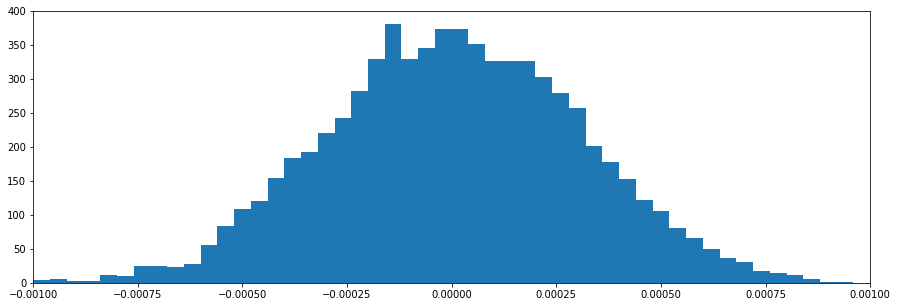

tensor(3.649379732459e-07, dtype=torch.float64)


In [10]:
# Set parameters (1 signal with length 8192)
dtype, device = torch.float64, 'cpu'
size, length = 1, 8192

# Set window
w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (1 signals with two components)
t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Generate matrix shifted signal
data = d.make_matrix(1024, 1, d.data[0])
w = Window.from_cosine(1024, order=1.0, dtype=dtype, device=device)
d = Data.from_data(w, data)
print(d)

# Add noise to each signal
for i in range(d.size):
    d.data[i] += 0.01*torch.randn(d.length, dtype=dtype, device=device)
d.reset()

# Initialize Frequency instance
f = Frequency(d)
print(f)

# Apply window (note, window is applied to work)
d.window_remove_mean()
d.window_apply()

# Estimate frequency, see also task_parabola
f('parabola')

# Compare results
print(torch.abs(torch.mean(f.fft_frequency)-0.12))
print(torch.abs(torch.mean(f.ffrft_frequency)-0.12))
print(torch.abs(torch.mean(f.parabola_frequency)-0.12))

# Plot result
plt.figure(figsize=(15,5))
plt.hist(100*(f.frequency.cpu().numpy()-0.12)/0.12, bins=50, range=(-1.0E-3, +1.0E-3))
plt.xlim(-1.0E-3, +1.0E-3)
plt.show()

# Spread
print(f.parabola_frequency.std().cpu())

# Clean
del w
del t, data
del d
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-10: Frequency vs signal start shift (correlated noise)

Window(8192, 'cosine_window', 1.0)
Data(1, Window(8192, 'cosine_window', 1.0))
Data(7169, Window(1024, 'cosine_window', 1.0))
Frequency(Data(7169, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(5.570128466803e-08, dtype=torch.float64)
tensor(8.571680643055e-09, dtype=torch.float64)


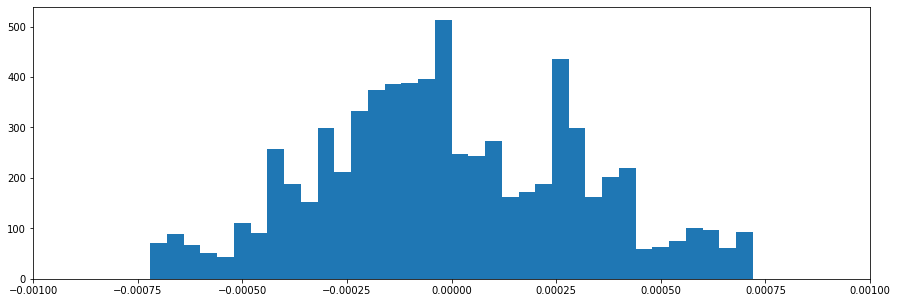

tensor(3.755888063949e-07, dtype=torch.float64)


In [11]:
# Set parameters (1 signal with length 8192)
dtype, device = torch.float64, 'cpu'
size, length = 1, 8192

# Set window
w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (1 signals with two components and random noise)
t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
data += 0.01*torch.randn(length, dtype=dtype, device=device)
d = Data.from_data(w, data)
print(d)

# Generate matrix shifted signal
data = d.make_matrix(1024, 1, d.data[0])
w = Window.from_cosine(1024, order=1.0, dtype=dtype, device=device)
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instance
f = Frequency(d)
print(f)

# Apply window (note, window is applied to work)
d.window_remove_mean()
d.window_apply()

# Estimate frequency, see also task_parabola
f('parabola')

# Compare results
print(torch.abs(torch.mean(f.fft_frequency)-0.12))
print(torch.abs(torch.mean(f.ffrft_frequency)-0.12))
print(torch.abs(torch.mean(f.parabola_frequency)-0.12))

# Plot result
plt.figure(figsize=(15,5))
plt.hist(100*(f.frequency.cpu().numpy()-0.12)/0.12, bins=50, range=(-1.0E-3, +1.0E-3))
plt.xlim(-1.0E-3, +1.0E-3)
plt.show()

# Spread
print(f.parabola_frequency.std().cpu())

# Clean
del w
del t, data
del d
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-11: Iterative decomposition

[2.]
[0.12 1.   0.1 ]
[0.24  0.005 0.01 ]
[3.6e-01 1.0e-04 1.0e-05]


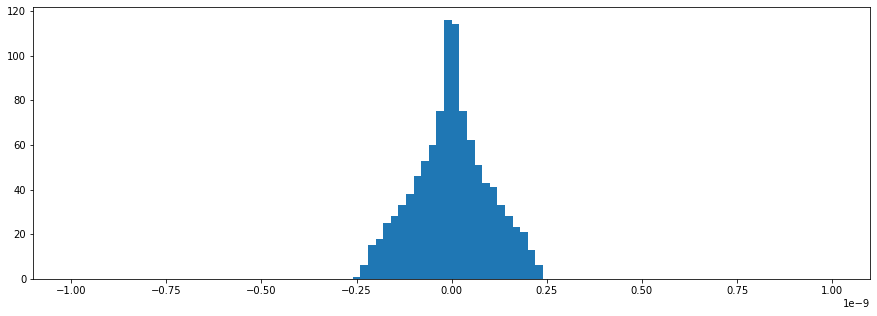

9.731337653646109e-11


In [12]:
# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 1, 1024

# Set window
w = Window.from_cosine(length, order=4.0, dtype=dtype, device=device)

# Set data
t  = torch.linspace(0.0, length-1, length, dtype=dtype, device=device)
data  = 1.0000*torch.cos(2.0*numpy.pi*1*0.12*t) + 0.10000*torch.sin(2.0*numpy.pi*1*0.12*t)
data += 0.0050*torch.cos(2.0*numpy.pi*2*0.12*t) + 0.01000*torch.sin(2.0*numpy.pi*2*0.12*t)
data += 0.0001*torch.cos(2.0*numpy.pi*3*0.12*t) + 0.00001*torch.sin(2.0*numpy.pi*3*0.12*t)
data += 2.0
data  = torch.stack([data])
d = Data.from_data(w, data)

# Compute (window weighted) mean value
print(d.window_mean().flatten().cpu().numpy())

# Remove (window weighted) mean value
# Note, mean is removed from work
d.window_remove_mean()
d.data.copy_(d.work)

# Initialize Frequency instance
f = Frequency(d)

# Perform decomposition (component-by-component subtraction)
for _ in range(3):
    
    # Remove mean and apply window
    d.window_apply()
    
    # Estimate main harmonic frequency
    f('parabola')
    frequency = f.frequency[0]
    
    # Estimate main harmonic parameters
    cos = 2.0*torch.dot(d.data[0]*w.window, torch.cos(2.0*numpy.pi*frequency*t))/w.total
    sin = 2.0*torch.dot(d.data[0]*w.window, torch.sin(2.0*numpy.pi*frequency*t))/w.total
    
    # Subtract harmonic
    harmonic = cos*torch.cos(2.0*numpy.pi*frequency*t) + sin*torch.sin(2.0*numpy.pi*frequency*t)
    d.data.sub_(harmonic)
    
    # Reset work
    d.reset()
    
    # Print result
    print(torch.stack([frequency, cos, sin]).cpu().numpy())
    

# Plot Residual
plt.figure(figsize=(15,5))
plt.hist(d.data[0].cpu().numpy(), bins=100, range=(-1.0E-9, +1.0E-9))
plt.show()

# Residual spread
print(d.data.std().item())

# Clean
del w
del t, data
del d
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-12: Mixed frequency (direct computation)

In [13]:
# Set window
device = 'cpu'
w = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device=device)

# Load test TbT data from file (linear lattice without noise)
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Remove mean and apply window
d.window_remove_mean()
d.window_apply()

# Compute reference frequency
f = Frequency(d)
f('parabola')
ref = f.frequency.mean()
print(ref.item())

# Generate mixed signal
keep = 32
data = d.data[:, :keep]
data = (data - data.mean(1).reshape(-1, 1))/data.std(1).reshape(-1, 1)
data = d.make_signal(keep, data)

# Generate window and TbT for mixed signal
w = Window(len(data), name='cosine_window', order=1.0, dtype=torch.float64, device=device)
d = Data.from_data(w, data.reshape(1, -1))
d.window_apply()

# Compute frequency
f = Frequency(d)
f('parabola', f_range=(8.5/54, 8.6/54))
res = 9.0 - 54*f.frequency.mean()
print(res.item())

# Compare
print((ref - res).item())

# Note, the above is also avalible as a separate method (work container is used)
w = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy')
f = Frequency(d)
*_, res = 9.0 - f.task_mixed_frequency(length=keep, f_range=(8.5, 8.6), order=1.0)
print(res.item())

# Clean
del w
del data
del d
del f
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

0.46311690126299115
0.4631161977901517
7.034728394805789e-07
0.4631161977901517


# Example-13: Mean spectrum

Window(4096, 'cosine_window', 1.0)
Data(54, Window(4096, 'cosine_window', 1.0))
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)), f_range=(0.0, 0.5))


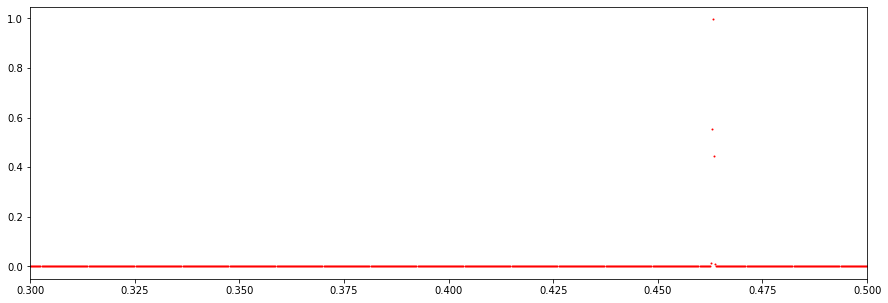

In [14]:
# Set window
device = 'cpu'
w = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device=device)
print(w)

# Load TbT data from file and add noise
d = Data.from_file(54, w, '../virtual_tbt.npy')
s = 1.0E-4*torch.ones(54, dtype=torch.float64)
d.add_noise(s)
print(d)

# Apply window (note, window is applied to work)
d.window_remove_mean()
d.window_apply()

# Initialize Frequency instance
f = Frequency(d)
print(f)

# Compute frequencies
# self.frequency container is used for normalization of each signal spectrum
f('parabola')

# Compute mean spectrum
# Note, spectra are not recomputed, normalization and averaging is performed
grid, spectrum = f.task_mean_spectrum(log=False)

# Plot mean spectrum
plt.figure(figsize=(15,5))
plt.xlim(0.3, 0.5)
plt.scatter(grid.cpu(), spectrum.cpu(), s=1, c='r')
plt.show()

# Clean
del w
del d
del f
del grid, spectrum
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-14: Mixed spectrum

Window(4096, 'cosine_window', 1.0)
Data(54, Window(4096, 'cosine_window', 1.0))
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)), f_range=(0.0, 0.5))


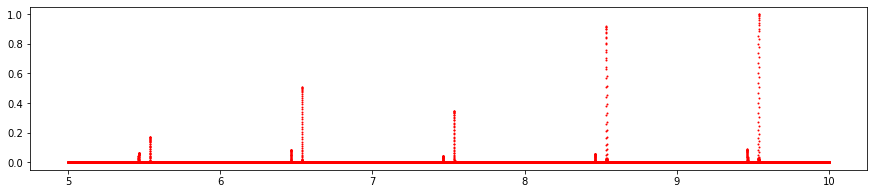

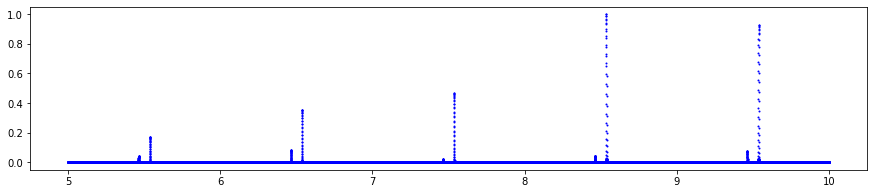

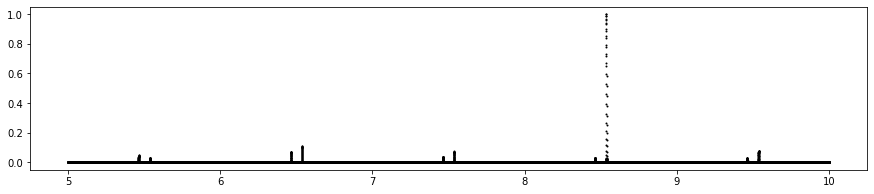

In [15]:
# Load model data
with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}

# Set normalized positions (used as locations with NUFFT)
position = numpy.array([value['S'] for key, value in config.items() if value['TYPE'] == 'MONITOR'])/LENGTH

# Set normalized accumulated phase advance between given monitor location and the next monitor location (used as locations with NUFFT)
phase = numpy.array([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR' or key == 'END'])
*_, tune = phase
phase = numpy.diff(phase)
phase = numpy.cumsum(phase)/tune
start, *_ = phase
phase = phase - start

# Set window
device = 'cpu'
w = Window(4096, name='cosine_window', order=1.0, dtype=torch.float64, device=device)
print(w)

# Load TbT data from file and add noise
d = Data.from_file(54, w, '../virtual_tbt.npy')
s = 1.0E-4*torch.ones(54, dtype=torch.float64)
d.add_noise(s)
print(d)

# Initialize Frequency instance
f = Frequency(d)
print(f)

# Compute & plot mixed spectrum
f_range=(5.0, 10.0)
s1 = f.task_mixed_spectrum(length=1024, normalize=True, f_range=f_range, name='cosine_window', order=1.0, position=None)
s2 = f.task_mixed_spectrum(length=1024, normalize=True, f_range=f_range, name='cosine_window', order=1.0, position=position)
s3 = f.task_mixed_spectrum(length=1024, normalize=True, f_range=f_range, name='cosine_window', order=1.0, position=phase)
plt.figure(figsize=(15,3))
plt.scatter(*s1, c='red', s=1)
plt.show()
plt.figure(figsize=(15,3))
plt.scatter(*s2, c='blue', s=1)
plt.show()
plt.figure(figsize=(15,3))
plt.scatter(*s3, c='black', s=1)
plt.show()

# Clean
del w
del d
del f
del s1, s2, s3
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    
# s1 -- (red)   pre-normalized mixed signal treated as if it is uniformly sampled
# s2 -- (blue)  pre-normalized mixed signal and type-iii nufft with BPM normalized position as location
# s3 -- (black) pre-normalized mixed signal and type-iii nufft with BPM normalized accumulated phase as location

# As it can be seen, here s1 gives wrong integer part (location of peak with maximum amplitude)
# But this is not always the case, filtering by beta function or phase can resolve this

# Normalization is performed before to mixing to make mixed signal closer to a stationary one
# Another option to reduce the effect of signal being non-stationary is to scale it with beta function
# Or to remove BPMs where amplitudes are not close enough, e.g. near IP

# Example-15: Mixed frequency (task)

In [16]:
# Load model data
with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}

# Set normalized positions (used as locations with NUFFT)
position = numpy.array([value['S'] for key, value in config.items() if value['TYPE'] == 'MONITOR'])/LENGTH

# Set normalized accumulated phase advance between given monitor location and the next monitor location (used as locations with NUFFT)
phase = numpy.array([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR' or key == 'END'])
*_, tune = phase
phase = numpy.diff(phase)
phase = numpy.cumsum(phase)/tune
start, *_ = phase
phase = phase - start
tune = tune/(2.0*numpy.pi)

# Set window
device = 'cpu'
w = Window(4096, name='cosine_window', order=2.0, dtype=torch.float64, device=device)
print(w)

# Load TbT data from file
d = Data.from_file(54, w, '../virtual_tbt.npy')
print(d)

# Initialize Frequency instance
f = Frequency(d)
print(f)

# Compute reference frequency
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
mean = 9.0 - torch.mean(f.frequency).item()
std = torch.std(f.frequency).item()
print(tune)
print(mean)
print(abs(mean-tune))
print(std)

# Compute mixed frequencies in given range
# Note, for small number of turns, result might be more accurate without window (set order to zero)
# For large number of turns 'uniform' case is more accurate (might indicate a numerical problem with nufft)

length = 32
f1 = f.task_mixed_frequency(length=length, f_range=(8.5,9.0), order=1.0, normalize=True)
f2 = f.task_mixed_frequency(length=length, f_range=(8.5,9.0), order=1.0, normalize=True, position=position)
f3 = f.task_mixed_frequency(length=length, f_range=(8.5,9.0), order=1.0, normalize=True, position=phase)
print(f1.cpu().numpy())
print(f2.cpu().numpy())
print(f3.cpu().numpy())
print((f1 - tune).abs().cpu().numpy())
print((f2 - tune).abs().cpu().numpy())
print((f3 - tune).abs().cpu().numpy())

# Clean
del w
del d
del f
del f1, f2, f3
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, 'cosine_window', 2.0)
Data(54, Window(4096, 'cosine_window', 2.0))
Frequency(Data(54, Window(4096, 'cosine_window', 2.0)), f_range=(0.0, 0.5))
8.536883098737361
8.536883098737315
4.618527782440651e-14
3.2377265211256743e-16
[8.53125    8.53689236 8.5368838 ]
[8.53676896 8.53689084 8.53689098]
[8.53676896 8.53687776 8.53687766]
[5.63309874e-03 9.26237375e-06 7.03472487e-07]
[1.14135217e-04 7.74121759e-06 7.87950808e-06]
[1.14135217e-04 5.33493356e-06 5.44336398e-06]


# Example-16: Mixed frequency (task, with noise)

In [17]:
# Load model data
with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}

# Set normalized positions (used as locations with NUFFT)
position = numpy.array([value['S'] for key, value in config.items() if value['TYPE'] == 'MONITOR'])/LENGTH

# Set normalized accumulated phase advance between given monitor location and the next monitor location (used as locations with NUFFT)
phase = numpy.array([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR' or key == 'END'])
*_, tune = phase
phase = numpy.diff(phase)
phase = numpy.cumsum(phase)/tune
start, *_ = phase
phase = phase - start
tune = tune/(2.0*numpy.pi)

# Set window
device = 'cpu'
w = Window(4096, name='cosine_window', order=2.0, dtype=torch.float64, device=device)
print(w)

# Load TbT data from file and add noise
d = Data.from_file(54, w, '../virtual_tbt.npy')
s = 1.0E-4*torch.ones(54, dtype=torch.float64)
d.add_noise(s)
d.data.copy_(d.work)
print(d)

# Initialize Frequency instance
f = Frequency(d)
print(f)

# Compute reference frequency
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
mean = 9.0 - torch.mean(f.frequency).item()
std = torch.std(f.frequency).item()
print(tune)
print(mean)
print(abs(mean-tune))
print(std)

# Compute mixed frequencies in given range
length = 32
f1 = f.task_mixed_frequency(length=length, f_range=(8.5,9.0), order=1.0, normalize=True)
f2 = f.task_mixed_frequency(length=length, f_range=(8.5,9.0), order=1.0, normalize=True, position=position)
f3 = f.task_mixed_frequency(length=length, f_range=(8.5,9.0), order=1.0, normalize=True, position=phase)
print(f1.cpu().numpy())
print(f2.cpu().numpy())
print(f3.cpu().numpy())
print((f1 - tune).abs().cpu().numpy())
print((f2 - tune).abs().cpu().numpy())
print((f3 - tune).abs().cpu().numpy())

# Clean
del w
del d
del f
del f1, f2, f3
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, 'cosine_window', 2.0)
Data(54, Window(4096, 'cosine_window', 2.0))
Frequency(Data(54, Window(4096, 'cosine_window', 2.0)), f_range=(0.0, 0.5))
8.536883098737361
8.536883125305092
2.6567731126192484e-08
3.072168524061256e-07
[8.53125    8.53674769 8.53675048]
[8.53676896 8.5367869  8.53678681]
[8.53676896 8.53682009 8.53682015]
[0.0056331  0.00013541 0.00013262]
[1.14135217e-04 9.61974197e-05 9.62937221e-05]
[1.14135217e-04 6.30041130e-05 6.29531968e-05]


# Example-17: Mean spectrum (masked component)


Window(1024, 'cosine_window', 1.0)
Data(128, Window(1024, 'cosine_window', 1.0))
Frequency(Data(128, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))


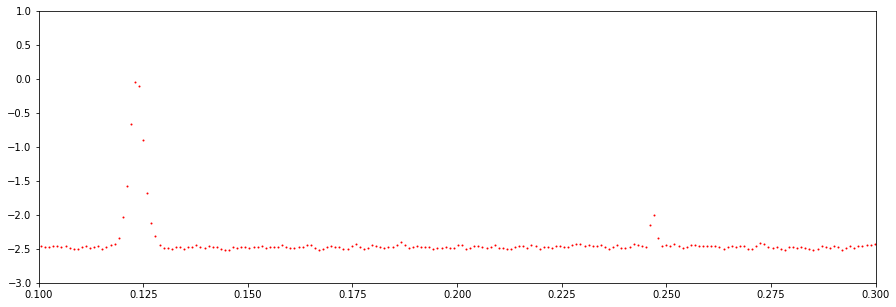

In [18]:
# Set window
device = 'cpu'
w = Window(1024, name='cosine_window', order=1.0, dtype=torch.float64, device=device)
print(w)

# Set data
t = torch.linspace(0.0, len(w)-1.0, len(w), dtype=w.dtype, device=w.device)
data = torch.cos(2.0*numpy.pi*0.12345*t) + 1.0E-2*torch.cos(2.0*numpy.pi*2.0*0.12345*t)
data = torch.stack([data + 5.0E-2*torch.randn(len(w)) for _ in range(128)])

# Set TbT
d = Data.from_data(w, data)
print(d)

# Apply window (note, window is applied to work)
d.window_remove_mean()
d.window_apply()

# Initialize Frequency instance
f = Frequency(d)
print(f)

# Compute frequencies
# self.frequency container is used for normalization of each signal spectrum
f('parabola')

# Compute mean spectrum
# Note, spectra are not recomputed, normalization and averaging is performed
grid, spectrum = f.task_mean_spectrum(log=True)

# Plot mean spectrum
plt.figure(figsize=(15,5))
plt.xlim(0.1, 0.3)
plt.ylim(-3.0, 1.0)
plt.scatter(grid.cpu(), spectrum.cpu(), s=1, c='r')
plt.show()

# Clean
del w
del d
del f
del grid, spectrum
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-18: Non-uniform sampling

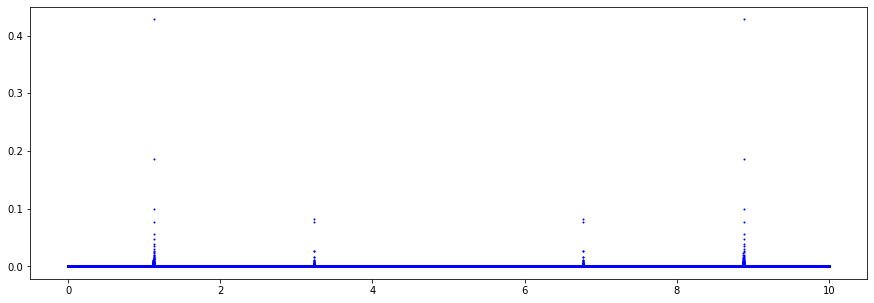

In [19]:
# Uniform sampling (stationary)

r = 10
l = 8192
t = torch.linspace(0.0, 1.0-1.0/r, r, dtype=torch.float64)
t = torch.cat([t + i for i in range(l)])

a = [1.0, 0.25]
f = [1.12345, 3.23456]
s = torch.sum(torch.stack([a[i]*torch.cos(2.0*numpy.pi*f[i]*t) for i in range(len(f))]), 0)

f_min, f_max = 0.0, 10.0
grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(t) + 1)
data = nufft.nufft1d3(t, s, grid)

plt.figure(figsize=(15, 5))
plt.scatter(grid/(2.0*numpy.pi), numpy.abs(data), c='b', s=1)
plt.show()

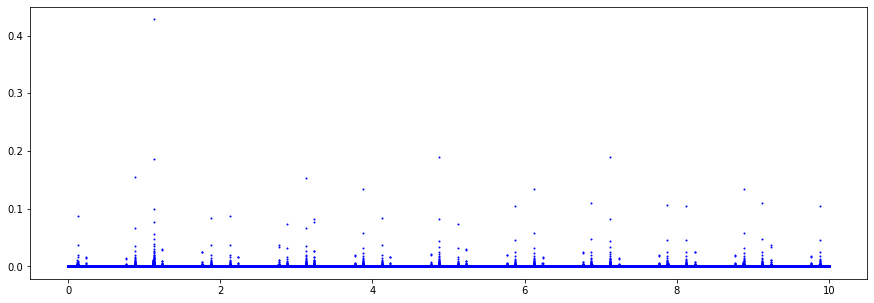

In [20]:
# Non-uniform periodic sampling (stationary)

r = 10
l = 8192
t = torch.sort(torch.rand(r, dtype=dtype)).values
t = torch.cat([t + i for i in range(l)])

a = [1.0, 0.25]
f = [1.12345, 3.23456]
s = torch.sum(torch.stack([a[i]*torch.cos(2.0*numpy.pi*f[i]*t) for i in range(len(f))]), 0)

f_min, f_max = 0.0, 10.0
grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(t) + 1)
data = nufft.nufft1d3(t, s, grid)

plt.figure(figsize=(15, 5))
plt.scatter(grid/(2.0*numpy.pi), numpy.abs(data), c='b', s=1)
plt.show()

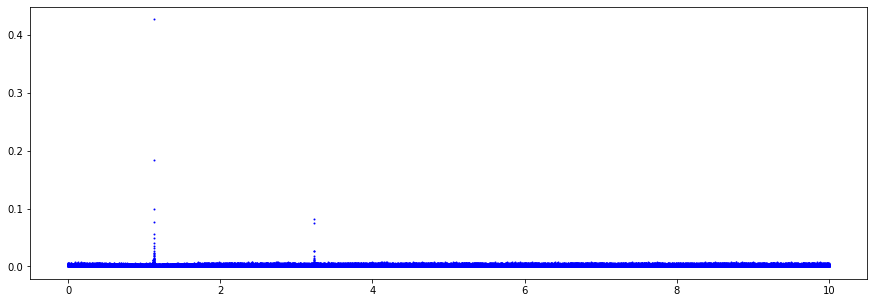

In [21]:
# Non-uniform random sampling (stationary)

r = 10
l = 8192
t = torch.cat([torch.sort(torch.rand(r, dtype=dtype)).values + i for i in range(l)])

a = [1.0, 0.25]
f = [1.12345, 3.23456]
s = torch.sum(torch.stack([a[i]*torch.cos(2.0*numpy.pi*f[i]*t) for i in range(len(f))]), 0)

f_min, f_max = 0.0, 10.0
grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(t) + 1)
data = nufft.nufft1d3(t, s, grid)

plt.figure(figsize=(15, 5))
plt.scatter(grid/(2.0*numpy.pi), numpy.abs(data), c='b', s=1)
plt.show()

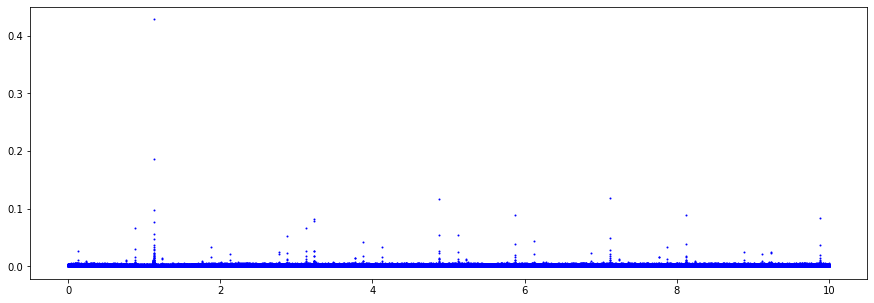

In [22]:
# Non-uniform periodic sampling with random choice (stationary)

c = 10
r = 5*10
l = 8192
t = torch.sort(torch.rand(r, dtype=dtype)).values
w = range(r)
t = torch.cat([torch.sort(t[numpy.random.choice(w, size=c, replace=False)]).values + i for i in range(l)])

a = [1.0, 0.25]
f = [1.12345, 3.23456]
s = torch.sum(torch.stack([a[i]*torch.cos(2.0*numpy.pi*f[i]*t) for i in range(len(f))]), 0)

f_min, f_max = 0.0, 10.0
grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(t) + 1)
data = nufft.nufft1d3(t, s, grid)

plt.figure(figsize=(15, 5))
plt.scatter(grid/(2.0*numpy.pi), numpy.abs(data), c='b', s=1)
plt.show()

# Example-19: Mixed frequency (threshold)

In [23]:
# Set beta threshold
beta = 50.0

# Load model data
with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}

# Set normalized positions (used as locations with NUFFT)
position = numpy.array([value['S'] for key, value in config.items() if value['TYPE'] == 'MONITOR' and value['BX'] <= beta])/LENGTH

# Set normalized accumulated phase advance between given monitor location and the next monitor location (used as locations with NUFFT)
phase = numpy.array([value['FX'] for key, value in config.items() if (value['TYPE'] == 'MONITOR' and value['BX'] <= beta) or key == 'END'])
*_, tune = phase
phase = numpy.diff(phase)
phase = numpy.cumsum(phase)/tune
start, *_ = phase
phase = phase - start
tune = tune/(2.0*numpy.pi)

# Set window
device = 'cpu'
w = Window(4096, name='cosine_window', order=2.0, dtype=torch.float64, device=device)
print(w)

# Load TbT data from file
d = Data.from_file(54, w, '../virtual_tbt.npy')
d = Data.from_data(w, torch.stack([signal for (signal, name) in zip(d, config) if config[name]['BX'] <= beta]))
print(d)

# Initialize Frequenshapeinstance
f = Frequency(d)
print(f)

# Compute reference frequency
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
mean = 9.0 - torch.mean(f.frequency).item()
std = torch.std(f.frequency).item()
print(tune)
print(mean)
print(abs(mean-tune))
print(std)

# Compute mixed frequencies in given range
length = 128
f1 = f.task_mixed_frequency(length=length, f_range=(8.0,9.0), order=1.0, normalize=True)
f2 = f.task_mixed_frequency(length=length, f_range=(8.0,9.0), order=1.0, normalize=True, position=position)
f3 = f.task_mixed_frequency(length=length, f_range=(8.0,9.0), order=1.0, normalize=True, position=phase)
print(f1.cpu().numpy())
print(f2.cpu().numpy())
print(f3.cpu().numpy())
print((f1 - tune).abs().cpu().numpy())
print((f2 - tune).abs().cpu().numpy())
print((f3 - tune).abs().cpu().numpy())

# Clean
del w
del d
del f
del f1, f2, f3
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, 'cosine_window', 2.0)
Data(52, Window(4096, 'cosine_window', 2.0))
Frequency(Data(52, Window(4096, 'cosine_window', 2.0)), f_range=(0.0, 0.5))
8.536883098737361
8.536883098737315
4.618527782440651e-14
3.3685495502282104e-16
[8.5390625  8.53688401 8.5368831 ]
[8.53688956 8.53688005 8.53688005]
[8.53688956 8.53688294 8.53688292]
[2.17940126e-03 9.15685716e-07 5.51684920e-10]
[6.45798691e-06 3.04775408e-06 3.05088603e-06]
[6.45798691e-06 1.57647554e-07 1.77992783e-07]


# Example-20: Uncertainty estimation with error propagation and fit

In [24]:
# Estimate frequency and amplitude uncertainty from multiple noise realizations

# Set parameters
dtype = torch.float64
device = 'cpu'
length = 1024

# Set signal (harmonic signal with two components)
time = torch.linspace(1, length, length, dtype=dtype, device=device)
signal = 1.0*torch.cos(2.0*numpy.pi*0.12345*time) + 0.1*torch.cos(2.0*numpy.pi*2.0*0.12345*time)

# Set TbT (signal copies with different noise realizations)
std = 0.10
w = Window.from_cosine(length, 1.0, dtype=dtype, device=device)
data = torch.stack([signal + std*torch.randn(length, dtype=dtype, device=device) for _ in range(1024)])
d = Data.from_data(w, data)

# Remove mean and apply window
d.window_remove_mean()
d.window_apply()

# Estimate frequency
f = Frequency(d)
f('parabola')
m_f, s_f = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()

# Reset work
d.reset()

# Print result
print(f'frequency: error={abs(0.12345 - m_f):<16.12}, spread={s_f:<16.12}')

# Estimate amplitude
c = 2.0/w.total*torch.sum(torch.cos(2.0*numpy.pi*m_f*time)*d.data*w.window, 1)
s = 2.0/w.total*torch.sum(torch.sin(2.0*numpy.pi*m_f*time)*d.data*w.window, 1)
a = torch.sqrt(c*c + s*s)
m_a, s_a = a.mean().cpu().item(), a.std().cpu().item()

# Print result
print(f'amplitude: error={abs(1.0 - m_a):<16.12}, spread={s_a:<16.12}')

frequency: error=8.28638241773e-08, spread=3.67760443878e-06
amplitude: error=6.34740507597e-05, spread=0.00523962927182


In [25]:
# Estimate amplitude uncertainty from one signal using error propagation
# Noise sigma is assumed to be known
# Frequency uncertainty contribution (generaly small) is ignored here

# Amplitude
def get_amplitude(frequency, signal):
    c = 2.0/w.total*torch.sum(torch.cos(2.0*numpy.pi*frequency*time)*signal*w.window)
    s = 2.0/w.total*torch.sum(torch.sin(2.0*numpy.pi*frequency*time)*signal*w.window)
    return torch.sqrt(c*c + s*s)

# Set signal
signal = torch.zeros(length, dtype=dtype, device=device)
signal, *_ = d
get_amplitude(m_f, signal)
signal.requires_grad_(True)
signal.grad = None

# Set covariance matrix
m = std**2 + torch.zeros(length, dtype=dtype, device=device)
m = torch.diag(m)

# Compute amplitude and gradient
a = get_amplitude(m_f, signal)
a.backward()
g = signal.grad

# Compute and compare uncertainty estimation
print(s_a)
print(torch.sqrt(torch.dot(g, torch.matmul(m, g))).detach().cpu().item())

0.00523962927182024
0.005412658773651804


w_min/w_max = 0.9875147940789751


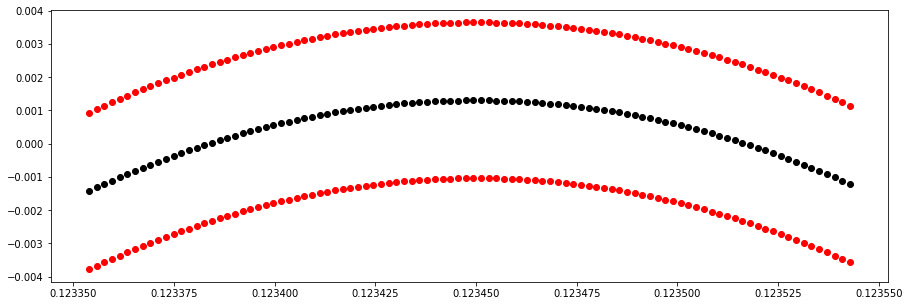

STD: 3.67760443878e-06
OLS: 2.88309506845e-06
WLS: 2.88309652578e-06


In [26]:
# Estimate frequency uncertainty from one signal using error propagation
# Noise sigma is assumed to be known
# For frequency, gradient can't be computed directry, since frequency estimation is an argmax problem
# In this case, for several frequencies near expected maximum location, corresponding DTFT amplitudes are computed
# A parabola can be then fitted and standart errors for coefficients can be estimated
# Error propagation can be used for each frequency value (or for minimum location), then weighted fit can be used
# In this example OLS and WLS are used from statmodels library
# Note, such frequency uncertainty estimation is not particularly accurate
# It depends on selected grid of frequencies and might over/under estimate
# Still, the order of magnitude can be somewhat meaningful

# Set a grid of frequencies near expected maximum
# Note, here ffrft grid is used for the 1st signal in TbT
# Here, 100 points near maximum are used, number of points should be increased/decreased for larger/smaller noise
size = 50
position, *_ = f.ffrft_bin.to(torch.int32)
grid = f.ffrft_get_grid()
grid = grid[position - size : position + size]

# Set signal
signal = torch.zeros(length, dtype=dtype, device=device)
signal, *_ = d
signal.requires_grad_(True)

# Set covariance matrix
m = std**2 + torch.zeros(length, dtype=dtype, device=device)
m = torch.diag(m)

# Amplitude (log10)
def get_amplitude(frequency, signal):
    c = 2.0/w.total*torch.sum(torch.cos(2.0*numpy.pi*frequency*time)*signal*w.window)
    s = 2.0/w.total*torch.sum(torch.sin(2.0*numpy.pi*frequency*time)*signal*w.window)
    return torch.log10(torch.sqrt(c*c + s*s))

# Compute amplitude and weight for each frequency
X = []
y = []
weight = []
for frequency in grid:
    X.append([frequency.cpu().item()**2, frequency.cpu().item(), 1.0])
    a = get_amplitude(frequency, signal)
    a.backward()
    g = signal.grad
    y.append(a.cpu().item())
    weight.append(1/torch.dot(g, torch.matmul(m, g)).detach().cpu().item())
    signal.grad = None
    
# Note, weights are close to one, i.e. OLS and WLS should be close
print(f'w_min/w_max = {min(weight)/max(weight)}')

# Plot amplitudes
plt.figure(figsize=(15, 5))
plt.scatter(grid.cpu(), y - numpy.sqrt(1/numpy.array(weight)), c='red')
plt.scatter(grid.cpu(), y, c='black')
plt.scatter(grid.cpu(), y + numpy.sqrt(1/numpy.array(weight)), c='red')
plt.show()

# Fit
from statsmodels.api import OLS, WLS
ols = OLS(y, X).fit()
wls = WLS(y, X, weights=numpy.array(weight)).fit()

# Print results
print(f'STD: {s_f:<16.12}')

a, b, c = ols.params
s_a, s_b, s_c = ols.bse
sigma = 1.0/(2.0*a**2)*numpy.sqrt(b**2*s_a**2+a**2*s_b**2)
print(f'OLS: {sigma:<16.12}')

a, b, c = wls.params
s_a, s_b, s_c = ols.bse
sigma = 1.0/(2.0*a**2)*numpy.sqrt(b**2*s_a**2+a**2*s_b**2)
print(f'WLS: {sigma:<16.12}')

# Note, this uncertainty estimation can be used to do weighted fit for different BPMs

In [27]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.844e+09
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:47:46   Log-Likelihood:                 1443.9
No. Observations:                 100   AIC:                            -2882.
Df Residuals:                      97   BIC:                            -2874.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.942e+05      4.858  -6.06e+04      0.0

In [28]:
print(wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.844e+09
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        11:47:47   Log-Likelihood:                 1444.0
No. Observations:                 100   AIC:                            -2882.
Df Residuals:                      97   BIC:                            -2874.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.942e+05      4.858  -6.06e+04      0.0

# Example-21: Generation and identification of harmonics

In [29]:
# For phase space of dimension 2N, quasiperiodic orbit contains N fundamental frequencies
# Other harmonics are combinations of this fundamental basis

# Generate harmonics (real signal with sampling rate equal to one)
order = 2
basis = [0.12, 0.31]
print()
for key, value in Frequency.harmonics(order, basis).items():
    print(key, value)
    
# Identify harmonics (for given basis and maximum order find closest harmonic)
order = 2
basis = [0.12, 0.31]
frequencies = Frequency.harmonics(order, basis).values()
print()
for key, value in Frequency.identify(order, basis, frequencies).items():
    print(key, value)


(0, 1) 0.31
(1, 0) 0.12
(0, 2) 0.38
(1, -1) 0.19
(1, 1) 0.43
(2, 0) 0.24

(0, 1) [0.31, 0.31, 0.0]
(1, 0) [0.12, 0.12, 0.0]
(0, 2) [0.38, 0.38, 0.0]
(1, -1) [0.19, 0.19, 0.0]
(1, 1) [0.43, 0.43, 0.0]
(2, 0) [0.24, 0.24, 0.0]


# Example-22: Frequency fit (task)

In [30]:
# In this example frequency (and its spread) is estimated for each signal using OLS/WLS fit
# Fit for each signal is performed using DTFT spectrum points near the expected maximum
# This provides estimation of frequency and its spread for a signal
# Data across signals can be used to fit (optionaly with weights) overall frequency

# These estimations are compared with estimations from multiple noise realizations
# And with estimations from time shifted signals

In [31]:
# Compute reference frequency
# Note, without noise, frequencies for different BPMs are equal within machine precision (for given length and window)

# Set parameters (signal length, data type and device)
length = 4096
dtype = torch.float64
device = 'cpu'

# Set window
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

# Load TbT
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Remove mean and apply window
d.window_remove_mean()
d.window_apply()

# Compute reference frequency
f = Frequency(d)
f('parabola')
m_ref, s_ref = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()

# Reset work
d.reset()

# Print results
print(f'{m_ref:<16.12}')
print(f'{s_ref:<16.12}')

0.463116901263  
1.22238738968e-16


In [32]:
# Set noise parameters

# All BPMs have different noise sigma
std = 1.0E-4*(4.0*torch.rand(54) + 1.0)

# One BPM has increased noise level
std[0] = 3.0E-3

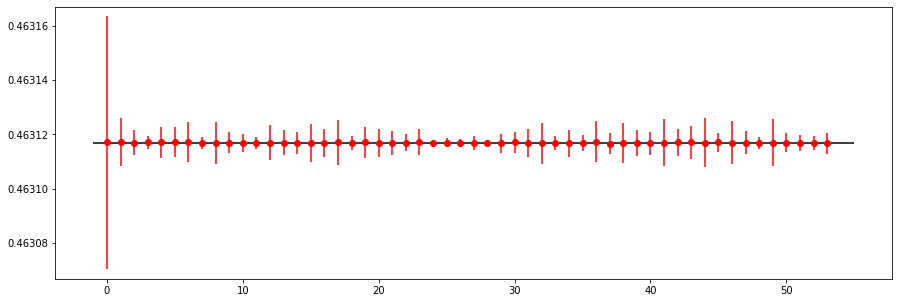

In [33]:
# Estimate spread for different noise realizations

# Iterate over noise realizations

table = []
count = 1024

for _ in range(count):
    w = Window(1024, 'cosine_window', 1.0, dtype=dtype, device=device)
    t = Data.from_data(w, d.data[:, :len(w)])
    t.add_noise(std)
    t.window_remove_mean()
    t.window_apply()
    f = Frequency(t)
    f('parabola')
    table.append(f.frequency)
    
table = torch.stack(table)

# Set mean and spread values for each BPM

m1, s1 = table.mean(0).cpu(), table.std(0).cpu()

# Plot results

plt.figure(figsize=(15, 5))
plt.errorbar(range(54), m1, yerr=s1, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

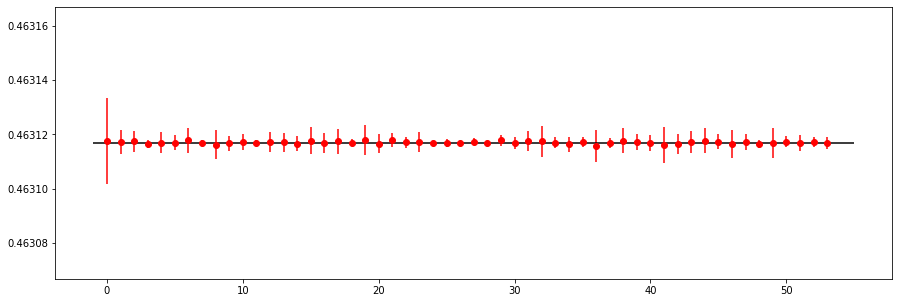

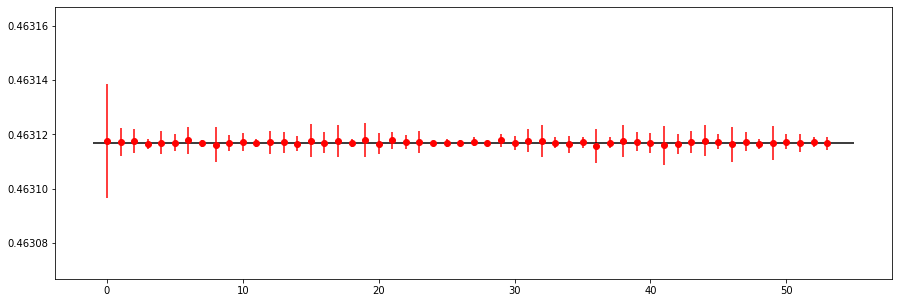

In [34]:
# Estimate spread from time shifted signals

# Load data

w = Window(length, dtype=dtype, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy')
d.add_noise(std)

# Iterate over signals

table = []

w = Window(1024, dtype=dtype, device=device)
for idx in range(d.size):
    t = d.make_matrix(length=w.length, shift=16, signal=d.work[idx])
    t = Data.from_data(w, t)
    t.window_remove_mean()
    t.window_apply()
    f = Frequency(t)
    f('parabola')
    table.append(f.frequency)
    
table = torch.stack(table)

# Set mean and spread values for each BPM
# Note, spread is computed as std

m2, s2 = table.mean(1).cpu(), table.std(1).cpu()

# Plot results

plt.figure(figsize=(15, 5))
plt.errorbar(range(54), m2, yerr=s2, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

# Set mean and spread values for each BPM
# Note, spread is computed from  peak-to-peak

f_min = table.min(1).values
f_max = table.max(1).values

m2 = table.mean(1).cpu()
s2 = 1/4.0*(f_max - f_min)

# Plot results

plt.figure(figsize=(15, 5))
plt.errorbar(range(54), m2, yerr=s2, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

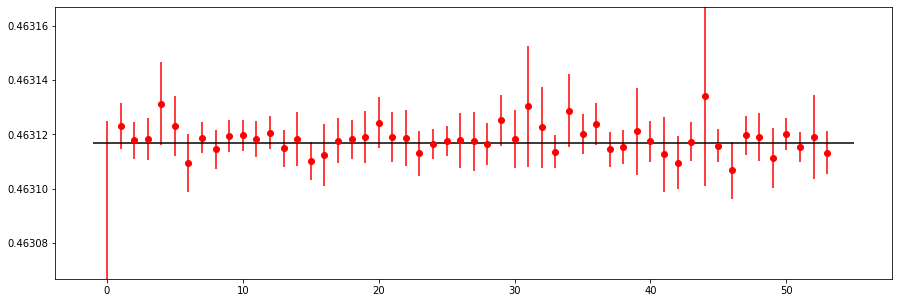

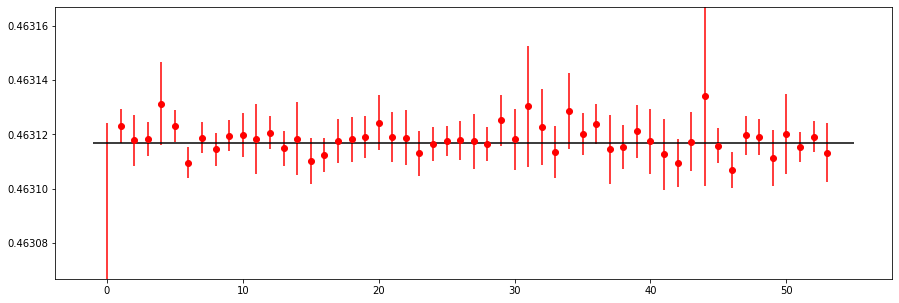

In [35]:
# Estimate spread from fit

# Load data
w = Window(1024, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy')
d.add_noise(std)

# Remove mean and apply window
d.window_remove_mean()
d.window_apply()

# Compute frequencies
f = Frequency(d)
f('parabola')

# Fit (ols)

out = f.task_fit(size=32, mode='ols')

# Set fitted frequencies and spread

m3, s3 = out.T

plt.figure(figsize=(15, 5))
plt.errorbar(range(54), m3, yerr=s3, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

# Fit (wls)

out = f.task_fit(size=32, mode='wls', std=std)

# Set fitted frequencies and spread

m3, s3 = out.T

plt.figure(figsize=(15, 5))
plt.errorbar(range(54), m3, yerr=s3, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

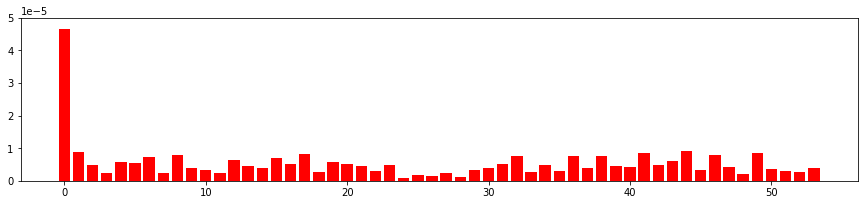

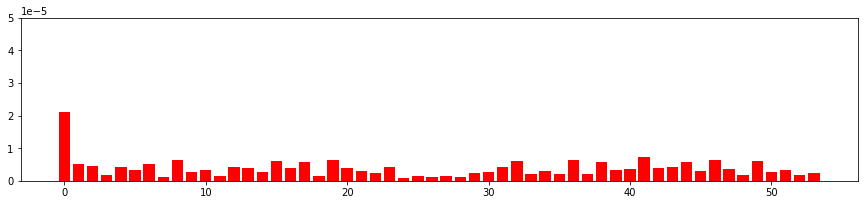

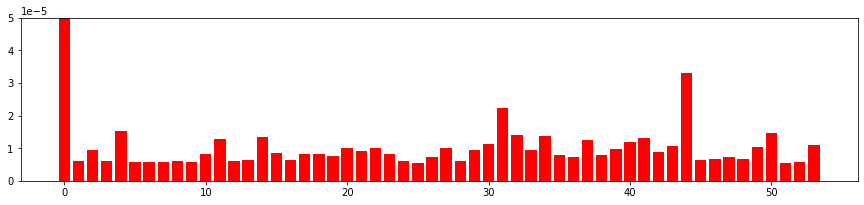

In [36]:
# Compare

plt.figure(figsize=(15, 3))
plt.bar(range(54), s1, color='red')
plt.ylim((0, 5.0E-5))
plt.show()

plt.figure(figsize=(15, 3))
plt.bar(range(54), s2, color='red')
plt.ylim((0, 5.0E-5))
plt.show()

plt.figure(figsize=(15, 3))
plt.bar(range(54), s3, color='red')
plt.ylim((0, 5.0E-5))
plt.show()

In [37]:
# Compare direct mean
print(abs(m_ref - m1.mean().cpu().item()))
print(abs(m_ref - m2.mean().cpu().item()))
print(abs(m_ref - m3.mean().cpu().item()))

5.3602015603892994e-08
1.606261113562546e-07
1.1667411392579652e-07


In [38]:
# Fit frequency for all BPMs

from statsmodels.api import OLS, WLS

X = numpy.ones(54).reshape(1, 54).T
y = m1.numpy()
w = (1/s1**2).cpu().numpy()

ols1 = OLS(y, X).fit()
wls1 = WLS(y, X, w).fit()

print(f'ols: err={abs(m_ref - ols1.params.item()):12.8}, std={ols1.bse.item():12.8}')
print(f'wls: err={abs(m_ref - wls1.params.item()):12.8}, std={wls1.bse.item():12.8}')

ols: err=5.3602016e-08, std=1.9052149e-08
wls: err=1.3050425e-08, std=1.1615169e-08


In [39]:
# Fit frequency for all BPMs using 'shifted' weights

from statsmodels.api import OLS, WLS

X = numpy.ones(54).reshape(1, 54).T
y = m2.numpy()
w = (1/s2**2).cpu().numpy()

ols2 = OLS(y, X).fit()
wls2 = WLS(y, X, w).fit()

print(f'ols: err={abs(m_ref - ols2.params.item()):12.8}, std={ols2.bse.item():12.8}')
print(f'wls: err={abs(m_ref - wls2.params.item()):12.8}, std={wls2.bse.item():12.8}')

ols: err=1.6062611e-07, std=6.4873936e-08
wls: err=1.4264266e-08, std=4.2532783e-08


In [40]:
# Fit frequency for all BPMs using 'fitted' weights

from statsmodels.api import OLS, WLS

X = numpy.ones(54).reshape(1, 54).T
y = m3.numpy()
w = (1/s3**2).cpu().numpy()

ols3 = OLS(y, X).fit()
wls3 = WLS(y, X, w).fit()

print(f'ols: err={abs(m_ref - ols3.params.item()):12.8}, std={ols3.bse.item():12.8}')
print(f'wls: err={abs(m_ref - wls3.params.item()):12.8}, std={wls3.bse.item():12.8}')

ols: err=1.1667411e-07, std=1.723805e-06
wls: err=4.873818e-07, std=6.014916e-07


# Example-23: Envelope and instantaneous frequency

In [41]:
# In this example DHT is used to compute signal envelope and instantaneous frequency

In [42]:
# Set test signal

length = 8192
dtype = torch.float64
device = 'cpu'

t = torch.linspace(1, length, length, dtype=dtype, device=device)
s = torch.exp(-0.0001*t*(1 + 0.25*torch.cos(2*numpy.pi*0.001*t)))*torch.cos(2.0*numpy.pi*0.12345*t).unsqueeze(0)

# Compute DHT
dht = Frequency.dht(s)

# Compute envelope
envelope = dht.abs()

# Compute instantaneous frequency
# Note, length is reduced by one
frequency = 1/(2.0*numpy.pi)*(dht[:, :-1]*dht[:, 1:].conj()).angle()

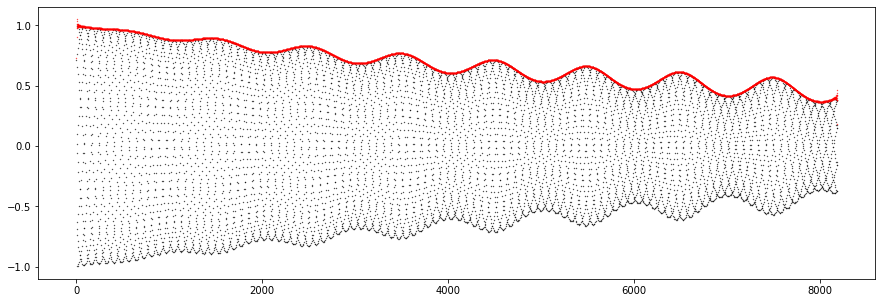

In [43]:
# Plot signal and envelope
# Note, result is not accurate at both ends
plt.figure(figsize=(15,5))
plt.scatter(range(length), s[0].cpu().numpy(), c='black', s=0.1)
plt.scatter(range(length), envelope[0].cpu().numpy(), c='red', s=0.1)
plt.show()

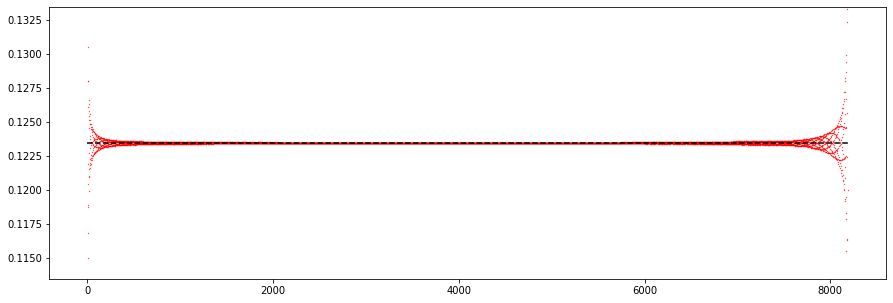

In [44]:
# Plot instantaneous frequency
# Note, result is not accurate at both ends
plt.figure(figsize=(15,5))
plt.ylim(0.12345-0.01, 0.12345+0.01)
plt.scatter(range(length-1), frequency[0].cpu().numpy(), c='red', s=0.1)
plt.hlines(0.12345, 1, length, color='black', linestyles='dashed')
plt.show()

# Example-24: Autocorrelation

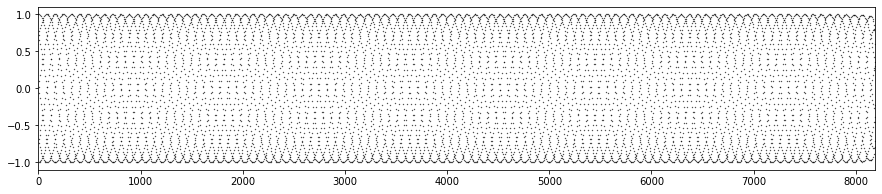

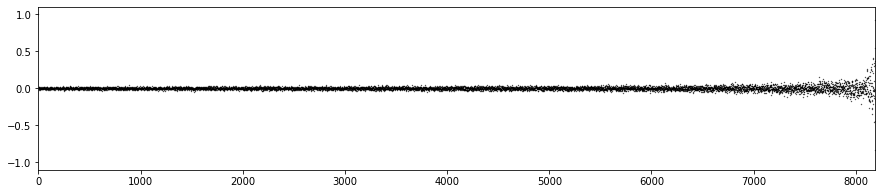

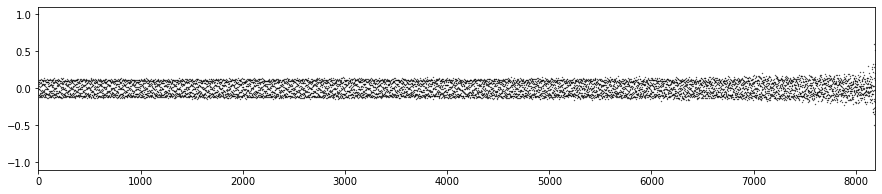

In [45]:
# Compute autocorrelation for harmonic, random noise and 'hidden' harmonic with noise

length = 8192
dtype = torch.float64
device = 'cpu'

s = torch.cos(2.0*numpy.pi*0.12345*torch.linspace(1, length, length, dtype=dtype, device=device)).unsqueeze(0)
auto1 = Frequency.autocorrelation(s)
plt.figure(figsize=(15, 3))
plt.scatter(range(length), auto1[0].cpu().numpy(), c='black', s=0.1)
plt.xlim(0, length + 1)
plt.ylim(-1.1, 1.1)
plt.show()

s = torch.randn((1, length), dtype=dtype, device=device)
auto2 = Frequency.autocorrelation(s)
plt.figure(figsize=(15, 3))
plt.scatter(range(length), auto2[0].cpu().numpy(), c='black', s=0.1)
plt.xlim(0, length + 1)
plt.ylim(-1.1, 1.1)
plt.show()

s = 0.5*torch.cos(2.0*numpy.pi*0.12345*torch.linspace(1, length, length, dtype=dtype, device=device)).unsqueeze(0)
s += torch.randn((1, length), dtype=dtype, device=device)
auto3 = Frequency.autocorrelation(s)
plt.figure(figsize=(15, 3))
plt.scatter(range(length), auto3[0].cpu().numpy(), c='black', s=0.1)
plt.xlim(0, length + 1)
plt.ylim(-1.1, 1.1)
plt.show()

[0.12345006 0.02625753 0.12345055]


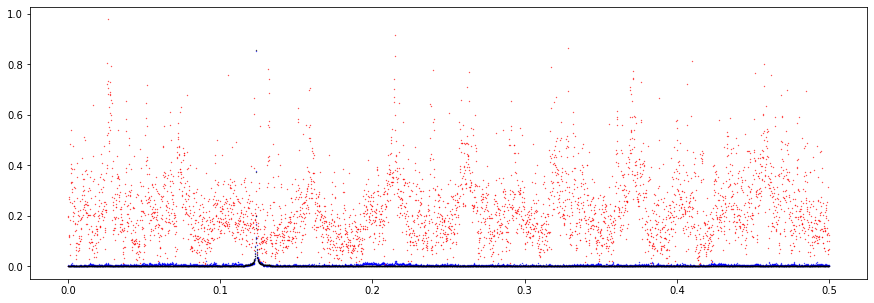

In [46]:
# Examine autocorrelation spectrum

w = Window.from_cosine(length, 0.0, dtype=dtype, device=device)
d = Data.from_data(w, torch.cat([auto1, auto2, auto3]))
d.window_remove_mean()
d.window_apply()
f = Frequency(d)
f('parabola')
print(f.frequency.cpu().numpy())

plt.figure(figsize=(15, 5))
plt.scatter(f.fft_grid, f.fft_spectrum[2]/f.ffrft_spectrum[2].max(), color='blue', s=0.1)
plt.scatter(f.fft_grid, f.fft_spectrum[1]/f.ffrft_spectrum[1].max(), color='red', s=0.1)
plt.scatter(f.fft_grid, f.fft_spectrum[0]/f.ffrft_spectrum[0].max(), color='black', s=0.1)
plt.show()

# Example-25: Frequency from shifted signals (task)

In [47]:
# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 2, 2**15

# Set window
w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set TbT
t = torch.linspace(1, length, length, dtype=dtype, device=device)
x = 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.10)
y = 0.50*torch.cos(2.0*numpy.pi*0.31*t + 0.50)
d = Data.from_data(w, torch.stack([x, y]))

# Add noise
d.add_noise(torch.tensor([1.0E-2, 1.0E-4], dtype=dtype, device=device))

# Estimate frequency from shifted signals
# Note, work is used in task_shift(), window is applied inside
f = Frequency(d)
out = f.task_shift(1024, 8)
print(out.shape)

torch.Size([2, 3969])


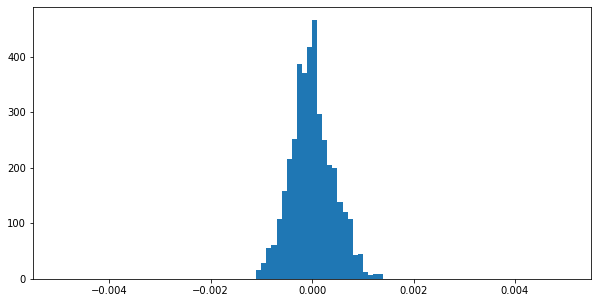

tensor(2.897528003226e-06, dtype=torch.float64)


In [48]:
# Plot result (1st signal)
plt.figure(figsize=(10,5))
plt.hist((out[0].cpu().numpy()-0.12)/0.12 * 100, bins=100, range=(-0.005, 0.005))
plt.show()
print(out[0].max() - out[0].min())

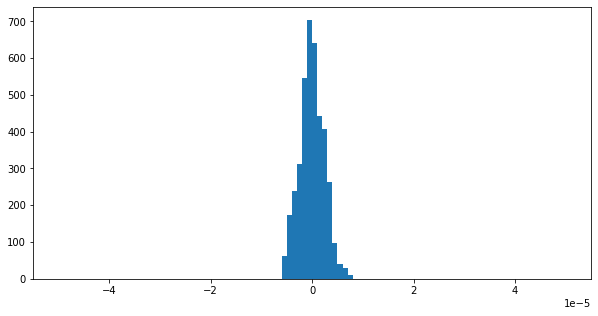

tensor(4.122801333661e-08, dtype=torch.float64)


In [49]:
# Plot result (2nd signal)
plt.figure(figsize=(10,5))
plt.hist((out[1].cpu().numpy()-0.31)/0.31 * 100, bins=100, range=(-0.00005, 0.00005))
plt.show()
print(out[1].max() - out[1].min())

# Example-26: Frequency estimation from complex data

In [50]:
# TbT data can be complex, in this case data type should be passed for Data(), Data.from_file() and Data.from_epics

# f < 1/2
w = Window.from_cosine(4096, 1.0, dtype=torch.float64)
c = torch.cos(2.0*numpy.pi*0.12*torch.linspace(1, w.length, w.length, dtype=torch.complex128))
s = torch.sin(2.0*numpy.pi*0.12*torch.linspace(1, w.length, w.length, dtype=torch.complex128))
d = torch.stack([c + 1j*s])
d = Data.from_data(w, d)
d.window_apply()
f = Frequency(d, f_range=(0.0, 1.0))
f('parabola')
print(f.frequency)

# f > 1/2
w = Window.from_cosine(4096, 1.0, dtype=torch.float64)
c = torch.cos(2.0*numpy.pi*0.88*torch.linspace(1, w.length, w.length, dtype=torch.complex128))
s = torch.sin(2.0*numpy.pi*0.88*torch.linspace(1, w.length, w.length, dtype=torch.complex128))
d = torch.stack([c + 1j*s])
d = Data.from_data(w, d)
d.window_apply()
f = Frequency(d, f_range=(0.0, 1.0))
f('parabola')
print(f.frequency)

tensor([1.200000000000e-01], dtype=torch.float64)
tensor([8.800000000000e-01], dtype=torch.float64)


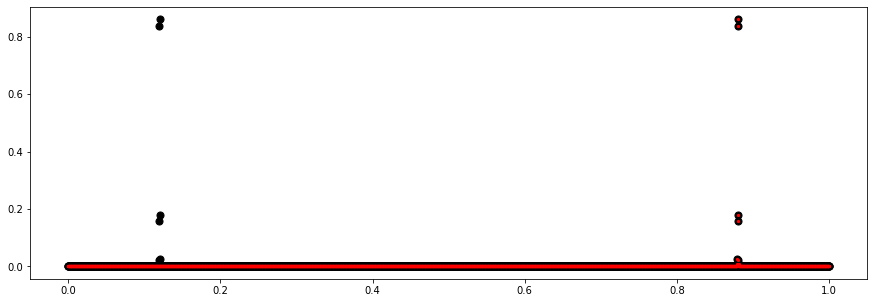

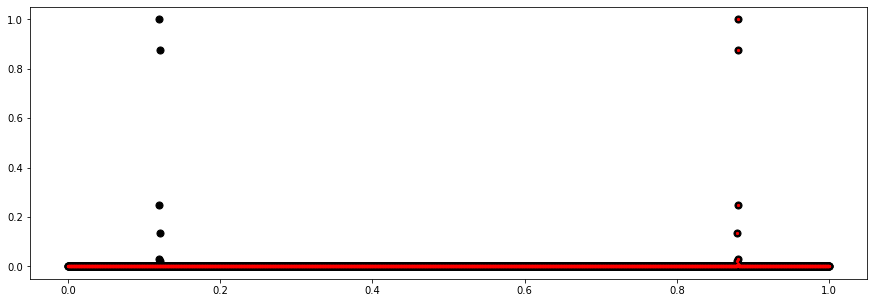

In [51]:
# Compare amplitude spectrum for real and complex data
# Note, correct iflag for nufft is -1 for complex data

# Real signal (FFT and NUFFT)
w = Window.from_cosine(4096, 1.0, dtype=torch.float64)
c = torch.cos(2.0*numpy.pi*0.88*torch.linspace(1, w.length, w.length, dtype=torch.complex128))
s = torch.sin(2.0*numpy.pi*0.88*torch.linspace(1, w.length, w.length, dtype=torch.complex128))
d = torch.stack([c])
d = Data.from_data(w, d)
d.window_apply()
f1 = Frequency(d, f_range=(0.0, 1.0))
f1('parabola')
d.reset()
g1, s1 = f1.task_mixed_spectrum(length=w.length, f_range=(0.0, 1.0), position=numpy.array([1.0]), iflag=-1)

# Complex signal (FFT and NUFFT)
w = Window.from_cosine(4096, 1.0, dtype=torch.float64)
c = torch.cos(2.0*numpy.pi*0.88*torch.linspace(1, w.length, w.length, dtype=torch.complex128))
s = torch.sin(2.0*numpy.pi*0.88*torch.linspace(1, w.length, w.length, dtype=torch.complex128))
d = torch.stack([c + 1j*s])
d = Data.from_data(w, d)
d.window_apply()
f2 = Frequency(d, f_range=(0.0, 1.0))
f2('parabola')
d.reset()
g2, s2 = f2.task_mixed_spectrum(length=w.length, f_range=(0.0, 1.0), position=numpy.array([1.0]), iflag=-1)

# Plot results (FFT spectum)
plt.figure(figsize=(15, 5))
plt.scatter(f1.fft_grid, f1.fft_spectrum[0]/f1.ffrft_spectrum[0].max(), s=50.0, color='black')
plt.scatter(f2.fft_grid, f2.fft_spectrum[0]/f2.ffrft_spectrum[0].max(), s=05.0, color='red')
plt.show()

# Plot results (NUFFT spectum)
plt.figure(figsize=(15, 5))
plt.scatter(g1, s1, s=50.0, color='black')
plt.scatter(g2, s2, s=05.0, color='red')
plt.show()

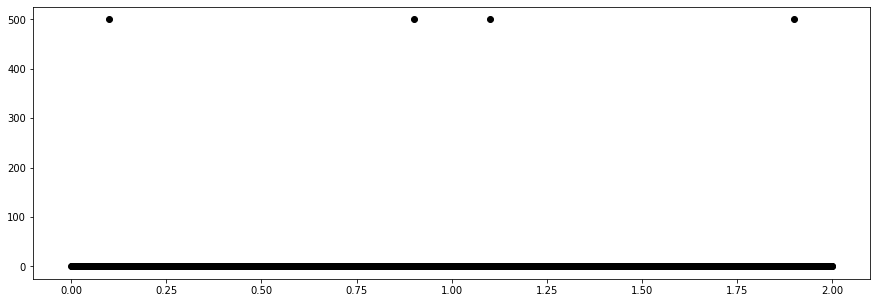

In [52]:
# Insert zeros

length = 1000
signal = torch.cos(2.0*numpy.pi*0.1*torch.linspace(1, length, length, dtype=torch.complex128))

insert = 1

mask = torch.zeros(1 + insert, dtype=torch.float64)
mask[0] = 1.0

signal = (mask*signal.reshape(-1, 1)).flatten().reshape(1, -1)

w = Window.from_cosine(length*(1 + insert), 0.0, dtype=torch.float64)
d = Data.from_data(w, signal)
d.window_apply()
f = Frequency(d)
f('fft')

plt.figure(figsize=(15, 5))
plt.scatter(f.fft_grid*(1 + insert), f.fft_spectrum[0], color='black')
plt.show()

# Example-27: Main frequency loop

In [53]:
# In this example the main frequency is estimated using different methods
# In all cases window is used and no data  filtering is performed
# Full signal length is 2048 turns

In [54]:
# Test cases:

# 1. Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
#    Estimate frequency as mean over signal and spread as standard deviation
#    Estimate frequency with OLS fit and spread as OLS standard error

# 2. Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
#    Estimate noise for each signal using optimal SVD and use it in WLS fit as weight

# 3. Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
#    Estimate standard error for each signal using OLS/WLS
#    Perform WLS fit for the main frequency and its spread

# 4. Estimate the main frequency for sampled signals using 'parabola' interpolation of refined amplitude spectrum
#    Estimate spread for each signal using standard deviation in sample frequencies
#    Perform WLS fit for the main frequency and its spread

# 5. Estimate the main frequency for sampled signals using 'parabola' interpolation of refined amplitude spectrum
#    Estimate noise for each sample, WLS fit to estimate sample spread
#    WLS fit samples to estimate signal frequency and its spread
#    WLS fit signlas to estimate the main frequency and its spread

In [55]:
# Import

import epics
import numpy
import pandas
import torch
import nufft

import sys
sys.path.append('..')

from harmonica.util import LENGTH
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

from statsmodels.api import OLS, WLS

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

True
6


In [56]:
# Reference case

# Set parameters
length = 2048
dtype = torch.float64
device = 'cpu'

# Set window
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load TbT
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Remove mean and apply window
d.window_remove_mean()
d.window_apply()

# Compute reference frequency
f = Frequency(d)
f('parabola')
f_ref, s_ref = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()

# Reset work
d.reset()

# Print results
print(f'{f_ref:<16.9}')
print(f'{s_ref:<16.9}')

0.463116901     
2.77869793e-16  


In [57]:
# Set data with noise

# Generate noise sigma for each signal
std = 1.0E-6*(50.0 + 150.0*torch.rand(54, dtype=dtype, device=device))

# Set increased noise
std[0] = 1.0E-6*300.0

# Set test data
d.reset()
d.add_noise(std)
data = d.work
print(data.shape)

# Set spike
data[1, 128] += 0.1

torch.Size([54, 2048])


In [58]:
# Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
# Estimate frequency as mean over signal and spread as standard deviation
# Estimate frequency with OLS fit and spread as OLS standard error

# Set data
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, data)

# Estimate frequency
t.window_remove_mean()
t.window_apply()
f = Frequency(t)
f('parabola')
t.reset()

# Estimate the main frequency and its spread using mean and standard deviation
f_out = f.frequency.mean().cpu().item()
s_out = f.frequency.std().cpu().item()
f_1, s_1 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

# Estimate the main frequency and its spread using OLS fit
x = numpy.ones((54, 1))
y = f.frequency.cpu().numpy()
out = OLS(y, x).fit()
f_out = out.params.item()
s_out = out.bse.item()
f_2, s_2 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

err: 9.5482834e-08   , std: 7.97503517e-07  
err: 9.54828339e-08  , std: 1.08526483e-07  


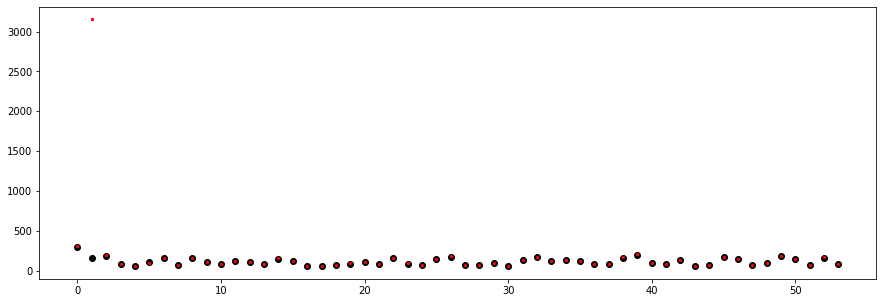

err: 1.08852864e-07  , std: 8.23848867e-08  


In [59]:
# Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
# Estimate noise for each signal using optimal SVD and use it in WLS fit as weight

# Set data
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, data)

# Estimate frequency
t.window_remove_mean()
t.window_apply()
f = Frequency(t)
f('parabola')
t.reset()

# Estimate noise
l = Filter(t)
_, s = l.estimate_noise(limit=32)

# Plot estimated noise and true noise
plt.figure(figsize=(15, 5))
plt.scatter(range(54), std*1.0E+6, color='black')
plt.scatter(range(54), s*1.0E+6, color='red', s=5)
plt.show()

# Estimate the main frequency and its spread using WLS fit
x = numpy.ones((54, 1))
y = f.frequency.cpu().numpy()
w = (1/s**2).cpu().numpy()
out = WLS(y, x, w).fit()
f_out = out.params.item()
s_out = out.bse.item()
f_3, s_3 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

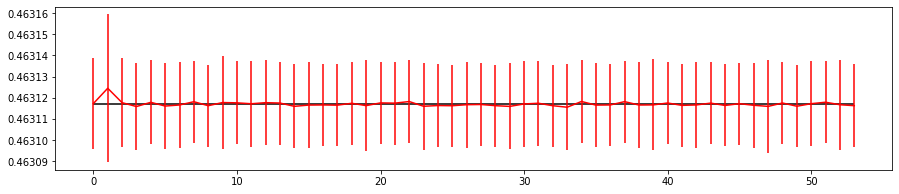

err: 1.43710867e-08  , std: 1.2692283e-07   


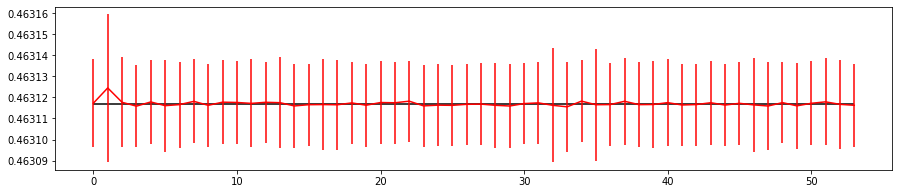

err: 2.25370929e-08  , std: 1.27617624e-07  


In [60]:
# Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
# Estimate standard error for each signal using OLS/WLS
# Perform WLS fit for the main frequency and its spread

# Set data
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, data)

# Estimate frequency
t.window_remove_mean()
t.window_apply()
f = Frequency(t)
f('parabola')
t.reset()

# Estimate noise
l = Filter(t)
_, s = l.estimate_noise(limit=32)

# OLS
f_out, s_out = f.task_fit(size=64, mode='ols').T
plt.figure(figsize=(15, 3))
plt.hlines(f_ref, 0, 53, color='black')
plt.errorbar(range(54), f_out.cpu().numpy(), yerr=s_out.cpu().numpy(), color='red')
plt.show()
x = numpy.ones((54, 1))
y = f_out.cpu().numpy()
w = (1/s_out**2).cpu().numpy()
out = WLS(y, x, w).fit()
f_out = out.params.item()
s_out = out.bse.item()
f_4, s_4 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

# WLS
f_out, s_out = f.task_fit(size=64, mode='wls', std=s).T
plt.figure(figsize=(15, 3))
plt.hlines(f_ref, 0, 53, color='black')
plt.errorbar(range(54), f_out.cpu().numpy(), yerr=s_out.cpu().numpy(), color='red')
plt.show()
x = numpy.ones((54, 1))
y = f_out.cpu().numpy()
w = (1/s_out**2).cpu().numpy()
out = WLS(y, x, w).fit()
f_out = out.params.item()
s_out = out.bse.item()
f_5, s_5 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

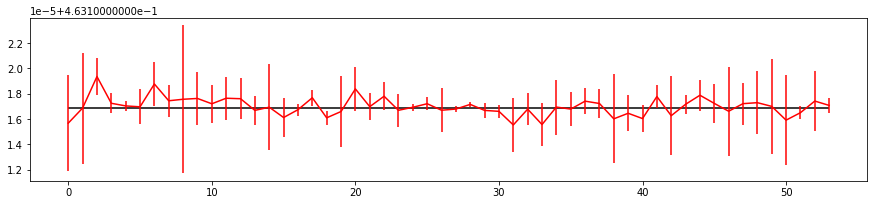

err: 6.13502132e-08  , std: 5.57490558e-08  


In [61]:
# Estimate the main frequency for sampled signals using 'parabola' interpolation of refined amplitude spectrum
# Estimate spread for each signal using standard deviation in sample frequencies
# Perform WLS fit for the main frequency and its spread

# Set data
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, data)

# Estimate frequency
t.window_remove_mean()
t.window_apply()
f = Frequency(t)
f('parabola')
t.reset()

# Estimated frequency for sampled data
out = f.task_shift(1024, 4)
f_out = out.mean(1)
s_out = out.std(1)
plt.figure(figsize=(15, 3))
plt.hlines(f_ref, 0, 53, color='black')
plt.errorbar(range(54), f_out.cpu().numpy(), yerr=s_out.cpu().numpy(), color='red')
plt.show()

# WLS fit
x = numpy.ones((54, 1))
y = f_out.cpu().numpy()
w = (1/s_out**2).cpu().numpy()
out = WLS(y, x, w).fit()
f_out = out.params.item()
s_out = out.bse.item()
f_6, s_6 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

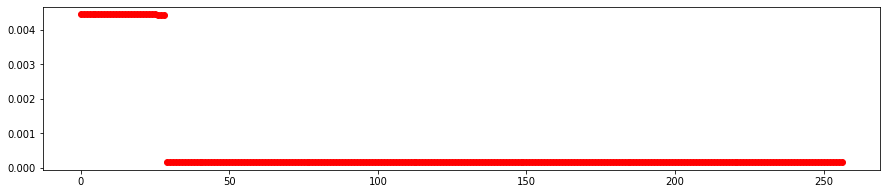

err: 5.7856377e-08   , std: 5.61801728e-08  


In [62]:
# Estimate the main frequency for sampled signals using 'parabola' interpolation of refined amplitude spectrum
# Estimate noise for each sample, WLS fit to estimate sample spread
# WLS fit samples to estimate signal frequency and its spread
# WLS fit signlas to estimate the main frequency and its spread

# Set data
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, data)

# Sample data
w = Window(1024, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, torch.cat([t.make_matrix(1024, 4, t.work[i]) for i in range(54)]))
n = t.size//54

# Estimate noise for all samples
l = Filter(t)
_, s = l.estimate_noise(limit=32)

# Plot noise estimation for signal with spike
plt.figure(figsize=(15, 3))
plt.scatter(range(n), s.reshape(54, -1)[1], color='red')
plt.show()

# Estimate frequency for each sample
t.window_remove_mean()
t.window_apply()
f = Frequency(t)
f('parabola')
t.reset()

# WLS fit samples
f_out = f.frequency.reshape(54, -1)
s_out = s.reshape(54, -1)
table = []
for i in range(54):
    x = numpy.ones((n, 1))
    y = f_out[i].cpu().numpy()
    w = (1/s_out[i]**2).cpu().numpy()
    out = WLS(y, x, w).fit()
    table.append([out.params.item(), out.bse.item()])
    
f_out, s_out = numpy.array(table).T

# WLS fit signals
x = numpy.ones((54, 1))
y = f_out
w = (1/s_out**2)
out = WLS(y, x, w).fit()
f_out = out.params.item()
s_out = out.bse.item()
f_7, s_7 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

In [63]:
# Compare results

# 1 -- mean & std over signals
# 2 -- OLS fit over signals
# 3 -- WLS fit over signals using estimated noise as weight
# 4 -- OLS fit for signal, WLS fit over signals
# 5 -- WLS fit for signal, WLS fit over signals
# 6 -- mean & std over samples, WLS fit over signals
# 7 -- WLS fit over samples, WLS fit over signals

print(f'case: 1, err: {abs(f_1 - f_ref):<16.9}, std: {s_1:<16.9}')
print(f'case: 2, err: {abs(f_2 - f_ref):<16.9}, std: {s_2:<16.9}')
print(f'case: 3, err: {abs(f_3 - f_ref):<16.9}, std: {s_3:<16.9}')
print(f'case: 4, err: {abs(f_4 - f_ref):<16.9}, std: {s_4:<16.9}')
print(f'case: 5, err: {abs(f_5 - f_ref):<16.9}, std: {s_5:<16.9}')
print(f'case: 6, err: {abs(f_6 - f_ref):<16.9}, std: {s_6:<16.9}')
print(f'case: 7, err: {abs(f_7 - f_ref):<16.9}, std: {s_7:<16.9}')

case: 1, err: 9.5482834e-08   , std: 7.97503517e-07  
case: 2, err: 9.54828339e-08  , std: 1.08526483e-07  
case: 3, err: 1.08852864e-07  , std: 8.23848867e-08  
case: 4, err: 1.43710867e-08  , std: 1.2692283e-07   
case: 5, err: 2.25370929e-08  , std: 1.27617624e-07  
case: 6, err: 6.13502132e-08  , std: 5.57490558e-08  
case: 7, err: 5.7856377e-08   , std: 5.61801728e-08  
